# Deep Q Network in CartPole environment
- Yuki Kitayama in Denver Quant Society
- 2020 October 11th

## Setup

In [13]:
# Google Colab needs to run the following to use env.render()
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

# neural network
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

import time
import pickle

# evaluation
import imageio

## Hyperparameters

In [29]:
ENV = 'CartPole-v0'

EPISODE = 5000
SAVE_INTERVAL = 1000
UPDATE_TARGET_INTERVAL = 30
MONITOR_INTERVAL = 100
EPSILON_DECAY = 0.999
EVALUATION_EPISODE = 5
PATH_EVALUATION_MODEL = 'dqn_cartpole_target_model_1000.h5'

PATH_MODEL = 'dqn_cartpole_target_model_'
PATH_REWARD_01 = 'dqn_cartpole_ep_reward.pkl'
PATH_REWARD_02 = 'dqn_cartpole_avg_reward.pkl'
PATH_EPSILON = 'dqn_cartpole_epsilon.pkl'
PATH_SAVEFIG_01 = 'dqn_cartpole_ep_reward_plot.png'
PATH_SAVEFIG_02 = 'dqn_cartpole_avg_reward_plot.png'
PATH_SAVEFIG_03 = 'dqn_cartpole_epsilon_plot.png'
PATH_VIDEO = 'dqn_cartpole_evaluation.gif'

LEARNING_RATE = 0.01
CAPACITY = 10000
MIN_EXPERIENCE = 100
BATCH_SIZE = 32
GAMMA = 0.99
EPSILON = 0.99
EPSILON_MIN = 0.1
MA = 100
FPS = 30
SEED = 0

plt.style.use('default')

## Model

In [15]:
def get_model(num_states, num_actions):
    inputs = Input(shape=(num_states,))
    x = Dense(128, activation='relu')(inputs)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_actions, activation='linear')(x)
    model = Model(inputs, outputs)
    return model

## Experience replay memory

In [16]:
class ExperienceReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = {'state': [],
                       'action': [],
                       'reward': [],
                       'next_state': [],
                       'done': []}
    def size(self):
        return len(self.buffer['state'])

    def store(self, experience_dict):
        if self.size() >= self.capacity:
            for key in self.buffer.keys():
                self.buffer[key].pop(0)
        for key, value in experience_dict.items():
            self.buffer[key].append(value)

## Auxiliary functions

In [17]:
def get_action(state, num_actions, model, epsilon):
    if np.random.random() < epsilon:
        return np.random.choice(num_actions)
    else:
        return np.argmax(model(np.atleast_2d(state.astype('float32')))[0])


def update_target(model, target_model):
    depth = len(target_model.trainable_variables)
    for i in range(depth):
        weight_model = model.trainable_variables[i]
        target_model.trainable_variables[i].assign(weight_model.numpy())
    return target_model


def update_model(model, target_model, memory, optimizer,
                 batch_size, gamma, num_actions):
    index = np.random.randint(low=0, high=memory.size(), size=batch_size)
    states = np.asarray([memory.buffer['state'][i] for i in index])
    actions = np.asarray([memory.buffer['action'][i] for i in index])
    rewards = np.asarray([memory.buffer['reward'][i] for i in index])
    next_states = np.asarray([memory.buffer['next_state'][i] for i in index])
    dones = np.asarray([memory.buffer['done'][i] for i in index])

    next_state_action_values = np.max(target_model(next_states), axis=1)
    target_values = np.where(dones, 
                             rewards,
                             rewards + gamma * next_state_action_values)
    
    with tf.GradientTape() as tape:
        action_values = tf.math.reduce_sum(
            model(np.atleast_2d(states.astype('float32'))) * tf.one_hot(actions, num_actions),
            axis=1
        )
        # Get loss function
        loss = tf.math.reduce_mean(tf.square(target_values - action_values))
    # Get weights
    variables = model.trainable_variables
    # Get gradients
    gradients = tape.gradient(loss, variables)
    # Gradient descent
    optimizer.apply_gradients(zip(gradients, variables))

## Training

In [12]:
# Environment
env = gym.make(ENV)
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
print(f'Environment: {ENV}\nState: {num_states}\nAction: {num_actions}')
print()

# Seed
env.seed(SEED)
np.random.random(SEED)
tf.random.set_seed(SEED)

# Model
model = get_model(num_states=num_states, num_actions=num_actions)
target_model = get_model(num_states=num_states, num_actions=num_actions)

# Optimizer
optimizer = Adam(learning_rate=LEARNING_RATE)

# Experience replay memory
memory = ExperienceReplayMemory(capacity=CAPACITY)

# Training initialization
epsilon = EPSILON
ep_reward = []
avg_reward = []
epsilons = []
start_time = time.time()


for ep in range(EPISODE):
    
    # Episode initialization
    total_reward = 0
    done = False
    state = env.reset()
    t = 0

    while not done:

        # Get action
        action = get_action(state, num_actions, model, epsilon)

        # Get next state and reward
        next_state, reward, done, _ = env.step(action)

        # Accumulate reward
        total_reward += reward

        # Store experience
        memory.store({'state': state, 'action': action, 'reward': reward, 
                      'next_state': next_state, 'done': done})
        
        # Update model
        if memory.size() > MIN_EXPERIENCE:
            update_model(model=model, target_model=target_model, memory=memory,
                         batch_size=BATCH_SIZE, gamma=GAMMA, 
                         num_actions=num_actions, optimizer=optimizer)
            
        # Next state becomes current state
        state = next_state

        # Count time step
        t += 1

        # Update target model
        if t % UPDATE_TARGET_INTERVAL == 0:
            target_model = update_target(model=model, target_model=target_model)

    # Decay epsilon
    epsilons.append(epsilon)
    epsilon = max(epsilon * EPSILON_DECAY, EPSILON_MIN)

    # Store reward result
    ep_reward.append(total_reward)
    ma_reward = np.mean(ep_reward[-MA:])
    avg_reward.append(ma_reward)

    # Monitor training
    if ep % MONITOR_INTERVAL == 0:
        print(f'Episode: {ep:,.0f}, avg reward: {ma_reward:,.1f}, '
              f'ep reward: {total_reward:,.1f}, epsilon: {epsilon:,.3f}, '
              f'minute: {((time.time() - start_time) / 60):,.1f}')

    # Save intemediate results
    if ep % SAVE_INTERVAL == 0:
        path = PATH_MODEL + str(ep) + '.h5'
        target_model.save_weights(path)
        pickle.dump(ep_reward, open(PATH_REWARD_01, 'wb'))
        pickle.dump(avg_reward, open(PATH_REWARD_02, 'wb'))
        pickle.dump(epsilons, open(PATH_EPSILON, 'wb'))
        print('Saved intermediate results')

# Save final results
path = PATH_MODEL + str(ep) + '.h5'
target_model.save_weights(path)
pickle.dump(ep_reward, open(PATH_REWARD_01, 'wb'))
pickle.dump(avg_reward, open(PATH_REWARD_02, 'wb'))
pickle.dump(epsilons, open(PATH_EPSILON, 'wb'))
print('Saved final results')

Environment: CartPole-v0
State: 4
Action: 2

Episode: 0, avg reward: 12.0, ep reward: 12.0, epsilon: 0.989, minute: 0.0
Saved intermediate results
Episode: 100, avg reward: 22.0, ep reward: 17.0, epsilon: 0.895, minute: 0.2
Episode: 200, avg reward: 25.0, ep reward: 16.0, epsilon: 0.810, minute: 0.5
Episode: 300, avg reward: 24.5, ep reward: 30.0, epsilon: 0.733, minute: 0.8
Episode: 400, avg reward: 26.9, ep reward: 45.0, epsilon: 0.663, minute: 1.1
Episode: 500, avg reward: 27.7, ep reward: 17.0, epsilon: 0.600, minute: 1.4
Episode: 600, avg reward: 31.9, ep reward: 39.0, epsilon: 0.543, minute: 1.8
Episode: 700, avg reward: 32.8, ep reward: 48.0, epsilon: 0.491, minute: 2.2
Episode: 800, avg reward: 35.1, ep reward: 24.0, epsilon: 0.444, minute: 2.6
Episode: 900, avg reward: 31.4, ep reward: 13.0, epsilon: 0.402, minute: 2.9
Episode: 1,000, avg reward: 31.3, ep reward: 21.0, epsilon: 0.364, minute: 3.3
Saved intermediate results
Episode: 1,100, avg reward: 39.5, ep reward: 34.0, eps

## Check training results

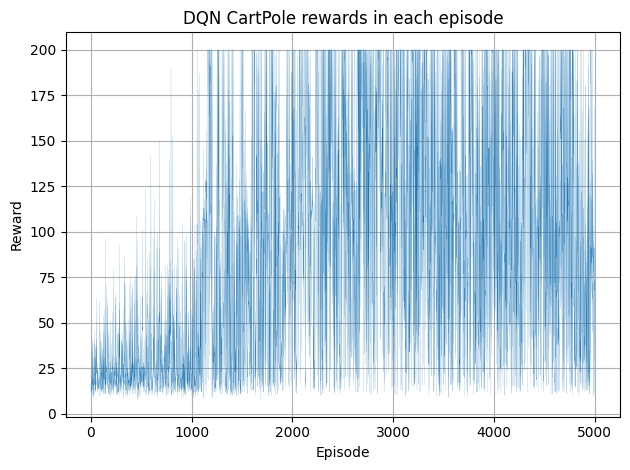

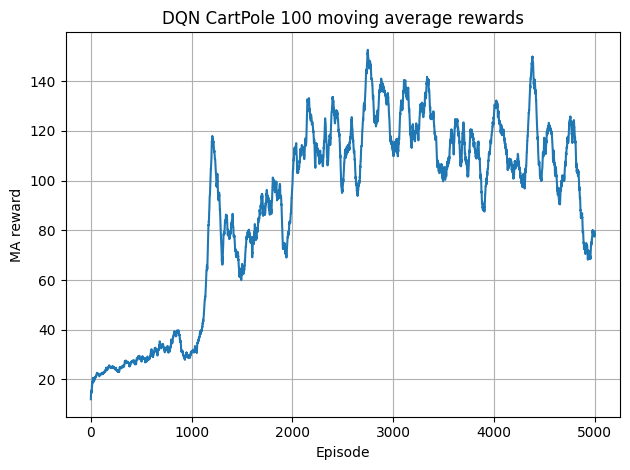

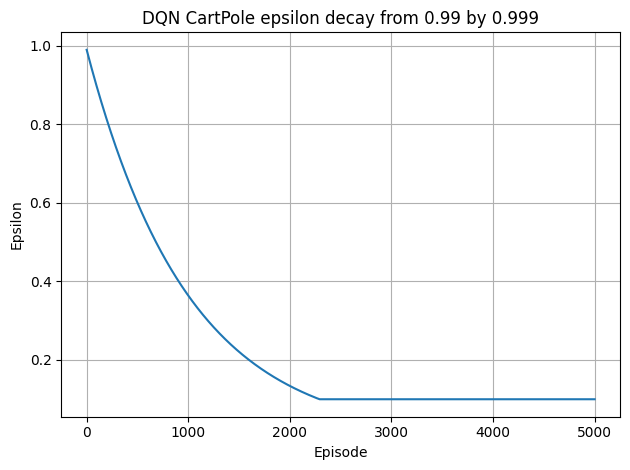

In [23]:
ep_reward = pickle.load(open(PATH_REWARD_01, 'rb'))
avg_reward = pickle.load(open(PATH_REWARD_02, 'rb'))
epsilons = pickle.load(open(PATH_EPSILON, 'rb'))

plt.plot(ep_reward, linewidth=0.1)
plt.title('DQN CartPole rewards in each episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)
plt.tight_layout()
plt.savefig(PATH_SAVEFIG_01)
plt.show()

plt.plot(avg_reward)
plt.title(f'DQN CartPole {MA} moving average rewards')
plt.xlabel('Episode')
plt.ylabel('MA reward')
plt.grid(True)
plt.tight_layout()
plt.savefig(PATH_SAVEFIG_02)
plt.show()

plt.plot(epsilons)
plt.title(f'DQN CartPole epsilon decay from {EPSILON} by {EPSILON_DECAY}')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid(True)
plt.tight_layout()
plt.savefig(PATH_SAVEFIG_03)
plt.show()

## Evaluation video

In [27]:
evaluation_model = get_model(num_states=num_states, num_actions=num_actions)
evaluation_model.load_weights(PATH_EVALUATION_MODEL)

with imageio.get_writer(PATH_VIDEO, fps=FPS) as video:

    for i in range(EVALUATION_EPISODE):

        # Initialize
        state = env.reset()
        doen = False
        screen = env.render(mode='rgb_array')
        video.append_data(screen)

        # Start episode
        while not done:

            # Get action
            action = evaluation_model(np.atleast_2d(state.astype('float32')))
            action = np.argmax(action[0])

            # Get next state
            next_state, _, done, _ = env.step(action)
            screen = env.render(mode='rgb_array')
            video.append_data(screen)
            
            # Iterate
            state = next_state

        print(f'Episode {i+1} finished')

    print(f'Made evaluation video')

Episode 1 finished
Episode 2 finished
Episode 3 finished
Episode 4 finished
Episode 5 finished
Made evaluation video
